# Natural Langugage Processing - TF-IDF
Authors: [RedSkittleFox](https://github.com/RedSkittleFox), [DJAltair](https://github.com/DJAltair)

# 1. Sourcing
Created a **corpora** for every book fetched using the requests library

In [1]:
import requests

books = []

books.append(requests.get("https://wolnelektury.pl/media/book/txt/makuszynski-o-dwoch-takich-co-ukradli-ksiezyc.txt"))
books.append(requests.get("https://wolnelektury.pl/media/book/txt/gide-lochy-watykanu.txt"))
books.append(requests.get("https://wolnelektury.pl/media/book/txt/hrabia-monte-christo.txt"))
books.append(requests.get("https://wolnelektury.pl/media/book/txt/pies-baskervilleow.txt"))
books.append(requests.get("https://wolnelektury.pl/media/book/txt/dolega-mostowicz-prokurator-alicja-horn.txt"))
books.append(requests.get("https://wolnelektury.pl/media/book/txt/homer-iliada.txt"))
books.append(requests.get("https://wolnelektury.pl/media/book/txt/homer-odyseja.txt"))

corpus = [x.text for x in books]
#corpus

# 2. Preprocessing

Using the nltk library we preprocess the corporas:

* remove stopwords
* remove tokens containing non-alphanumeric characters
* apply lowercase

In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('punkt_tab')

True

In [3]:
stopwords = requests.get("https://raw.githubusercontent.com/bieli/stopwords/refs/heads/master/polish.stopwords.txt")
stopwords = stopwords.text.split("\n")

corpus_tokenized = []

for i in range(len(corpus)):
  corpus_tokenized.append(nltk.word_tokenize(corpus[i]))
  corpus_tokenized[i] = [word.lower() for word in corpus_tokenized[i]]
  corpus_tokenized[i] = [word for word in corpus_tokenized[i] if word.isalpha()]
  corpus_tokenized[i] = [word for word in corpus_tokenized[i] if word not in stopwords]

#corpus_tokenized

In [4]:
len(corpus_tokenized[0])

33318

# 3. Word Frequency and Zipf Law

For each document we create frequency plots. Every plot roughly follows the Zipf's Law

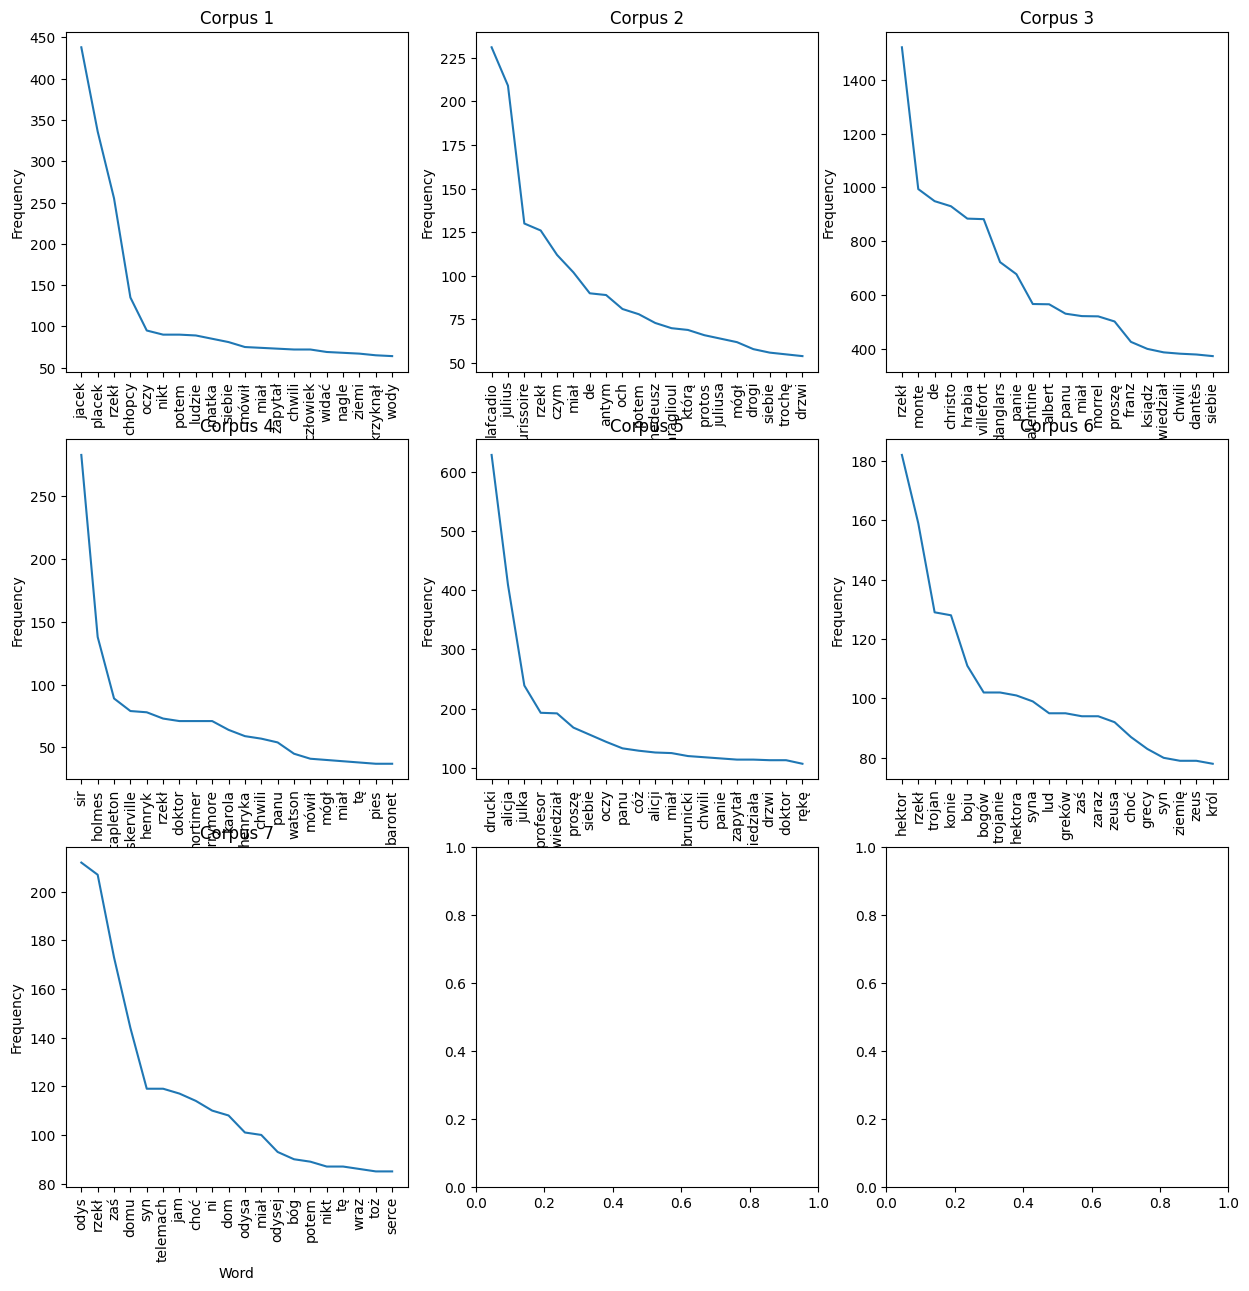

In [5]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt

corpus_wordfreq = [Counter(corpus) for corpus in corpus_tokenized]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
flat_axs = np.array(axs).flatten()

i = 0
for wordfreq in corpus_wordfreq:
  temp = list(wordfreq.items())
  temp.sort(key = lambda x : x[1], reverse=True)
  temp = temp[:20]
  x, y = zip(*temp)
  flat_axs[i].plot(x, y)
  flat_axs[i].set_title(f'Corpus {i+1}')
  flat_axs[i].set_xlabel('Word')
  flat_axs[i].set_ylabel('Frequency')
  flat_axs[i].tick_params(axis='x', rotation=90)

  i += 1

plt.show()


# 4. TF-IDF
We are creating a TF-IDF matrix for the corpuses using TfidfVectorizer

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus_string = []
for corpus in corpus_tokenized:
  corpus_string.append(' '.join(corpus))

word_set = {x for xs in corpus_tokenized for x in xs}
len(word_set)

tfidf = TfidfVectorizer(vocabulary=word_set).fit_transform(raw_documents=corpus_string)
tfidf

<7x79293 sparse matrix of type '<class 'numpy.float64'>'
	with 135495 stored elements in Compressed Sparse Row format>

# 5. Document similarity

Using cosine similarity we find similarities between documents for each pair of documents in the corpus.

In [7]:
import itertools
import sys
from sklearn.metrics.pairwise import cosine_similarity

n_books = len(books)

similarity_matrix = np.zeros((n_books, n_books))

for x, y in itertools.combinations(range(n_books), 2):
    similarity = cosine_similarity(tfidf.getrow(x), tfidf.getrow(y))[0][0]
    similarity_matrix[x, y] = similarity
    similarity_matrix[y, x] = similarity

np.fill_diagonal(similarity_matrix, 1)

np.savetxt(sys.stdout, similarity_matrix, fmt="%.3f", delimiter="\t")

1.000	0.123	0.172	0.088	0.111	0.133	0.170
0.123	1.000	0.257	0.112	0.149	0.116	0.155
0.172	0.257	1.000	0.136	0.179	0.151	0.202
0.088	0.112	0.136	1.000	0.110	0.083	0.117
0.111	0.149	0.179	0.110	1.000	0.099	0.131
0.133	0.116	0.151	0.083	0.099	1.000	0.396
0.170	0.155	0.202	0.117	0.131	0.396	1.000


## Thoughts: 
* Documents 6 and 7 have the most similarities (highest score). This is to be expected - both books have a similar setting (Iliad and Odyssey)

# 6. PCA
Using PCA (Principal Component Analysis) we represent each document as a point in 2-dimensional space.

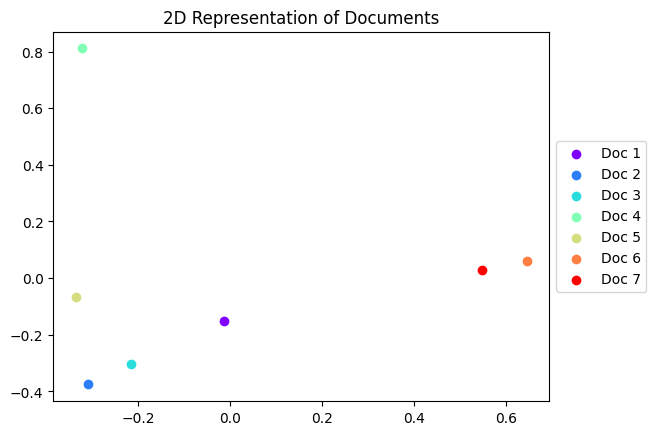

In [8]:
from sklearn.decomposition import PCA

tfidf_dense = tfidf.toarray()

pca_result = PCA().fit_transform(tfidf_dense)

pca_result

import numpy as np
num_docs = pca_result.shape[0]
colors = plt.cm.rainbow(np.linspace(0, 1, num_docs))

for i in range(num_docs):
    plt.scatter(pca_result[i, 0], pca_result[i, 1], color=colors[i], label=f'Doc {i+1}')
plt.title('2D Representation of Documents')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Thoughts:
* As expected documents 6 and 7 are really close on the plot as they represent a similar story setting - their cosine similarity is also high (40%).
* Also documents 2 and 3 are close on the plot, this relation is also seen on the similarity matrix (26%).